In [1]:
#!pip install validators
#!pip install torch torchvision torchaudio
#!pip install wget
#%pip uninstall --yes torch torchvision torchaudio
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu115
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.utils as vutils

from PIL import Image
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import shutil
from collections import Counter
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [4]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

resnet50.fc = nn.Sequential(
               nn.Linear(2048, 36),
               nn.Dropout(p=0.02),
               nn.ReLU(inplace=True),
               nn.Linear(36, 36),
               nn.Softmax()).to(device)                                             

torch.autograd.set_detect_anomaly(True)               


In [6]:
DATADIR = "BeeMachine_quarter"
CATEGORIES = ["Bombus_affinis", "Bombus_appositus", "Bombus_auricomus", "Bombus_bifarius", "Bombus_bimaculatus", "Bombus_borealis", 
             "Bombus_caliginosus", "Bombus_centralis", "Bombus_citrinus", "Bombus_crotchii", "Bombus_cryptarum", "Bombus_fernaldae_flavidus", 
             "Bombus_fervidus_californicus", "Bombus_flavifrons", "Bombus_fraternus", "Bombus_frigidus", "Bombus_griseocollis", "Bombus_huntii", 
             "Bombus_impatiens", "Bombus_insularis", "Bombus_melanopygus", "Bombus_mixtus", "Bombus_morrisoni", "Bombus_nevadensis", 
             "Bombus_occidentalis", "Bombus_pensylvanicus_sonorus", "Bombus_perplexus","Bombus_rufocinctus", "Bombus_sandersoni",
             "Bombus_sitkensis", "Bombus_sylvicola", "Bombus_ternarius", "Bombus_terricola", "Bombus_vagans", "Bombus_vandykei", 
             "Bombus_vosnesenskii"]

Import Data

In [7]:
import os

dataset = {}

def create_dataset():
    image_cap = 400
    for category in CATEGORIES:
        img_filenames = []
        path = os.path.join(DATADIR,category)
        cnt = 0  
        for img in os.listdir(path):
            try:
                img_filenames.append(os.path.join(path,img))
                cnt = cnt + 1
            except Exception as e:
                pass
            if cnt >= image_cap:
                break
        dataset[category] = img_filenames
        
create_dataset()


Separate data to train and validation dataset

In [7]:
def deleteFolder(pathToDelete):
    try:
        dir_path = os.path.join(DATADIR,pathToDelete)
        shutil.rmtree(dir_path)
    except OSError as e:
        print("Error: %s : %s" % (dir_path, e.strerror))

In [8]:

training_list = []
def separate_train_and_validate_dataset(dataset, training_list):
    for category in dataset:
        img_file_train, img_file_test = train_test_split(dataset[category], test_size=0.2, random_state=42)
        #deleteFolder('train')
        trainPath = os.path.join(DATADIR,'train',category)
        isExist = os.path.exists(trainPath)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(trainPath)
            #print("The new directory {} is created!".format(trainPath))
        for f in img_file_train:
            shutil.copy(f, trainPath)
        training_list.append(category)
        #deleteFolder('validation')
        validationPath = os.path.join(DATADIR,'validation',category)
        isExist = os.path.exists(validationPath)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(validationPath)
            #print("The new directory {} is created!".format(validationPath))

        for f in img_file_test:
            shutil.copy(f, validationPath)
                
separate_train_and_validate_dataset(dataset, training_list)

In [9]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(DATADIR + '\\train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(DATADIR + '\\validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

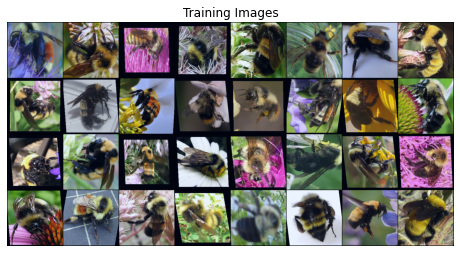

In [10]:
# Plot some training images
real_batch = next(iter(dataloaders['train']))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:

weights = class_weight.compute_class_weight('balanced', np.unique(training_list), training_list)
class_weights=torch.tensor(weights,dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(class_weights)
optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.0001, momentum=0.9)

In [12]:
n_epochs = 5
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(dataloaders['train'])

def train_model_new(model, dataloaders, criterion, optimizer, valid_loss_min, val_loss, val_acc
                , train_loss, train_acc, total_step, num_epochs=3):
    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        correct = 0
        total=0
        print(f'Epoch {epoch}\n')
        for batch_idx, (data_, target_) in enumerate(dataloaders['train']):
            data_, target_ = data_.to(device), target_.to(device)
            optimizer.zero_grad()
            
            outputs = model(data_)
            loss = criterion(outputs, target_)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==target_).item()
            total += target_.size(0)
            if (batch_idx) % 20 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
        train_acc.append(100 * correct / total)
        train_loss.append(running_loss/total_step)
        print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
        batch_loss = 0
        total_t=0
        correct_t=0
        with torch.no_grad():
            model.eval()
            for data_t, target_t in (dataloaders['validation']):
                data_t, target_t = data_t.to(device), target_t.to(device)
                outputs_t = model(data_t)
                loss_t = criterion(outputs_t, target_t)
                batch_loss += loss_t.item()
                _,pred_t = torch.max(outputs_t, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            val_acc.append(100 * correct_t/total_t)
            val_loss.append(batch_loss/len(dataloaders['validation']))
            network_learned = batch_loss < valid_loss_min
            print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

            
            if network_learned:
                modelPath = 'models/pytorch'
                isExist = os.path.exists(modelPath)
                if not isExist:
                    # Create a new directory because it does not exist 
                    os.makedirs(modelPath)
                    print("The new directory {} is created!".format(modelPath))
                valid_loss_min = batch_loss
                torch.save(model.state_dict(), 'models/pytorch/traiend_resnet50.h5')
                print('Improvement-Detected, save-model')
        model.train()
    return model



In [13]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.cuda()
                labels = labels.cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [13]:
#model_trained = train_model(resnet50, criterion, optimizer, num_epochs=3)
model_trained = train_model_new(resnet50, dataloaders, criterion, optimizer, valid_loss_min, val_loss, val_acc, train_loss, train_acc, total_step, n_epochs)

Epoch 1

Epoch [1/5], Step [0/330], Loss: 3.5837
Epoch [1/5], Step [20/330], Loss: 3.5831
Epoch [1/5], Step [40/330], Loss: 3.5832
Epoch [1/5], Step [60/330], Loss: 3.5830
Epoch [1/5], Step [80/330], Loss: 3.5823
Epoch [1/5], Step [100/330], Loss: 3.5830
Epoch [1/5], Step [120/330], Loss: 3.5826
Epoch [1/5], Step [140/330], Loss: 3.5832
Epoch [1/5], Step [160/330], Loss: 3.5847
Epoch [1/5], Step [180/330], Loss: 3.5848
Epoch [1/5], Step [200/330], Loss: 3.5833
Epoch [1/5], Step [220/330], Loss: 3.5835
Epoch [1/5], Step [240/330], Loss: 3.5831
Epoch [1/5], Step [260/330], Loss: 3.5850
Epoch [1/5], Step [280/330], Loss: 3.5836
Epoch [1/5], Step [300/330], Loss: 3.5842
Epoch [1/5], Step [320/330], Loss: 3.5830

train-loss: 3.5836, train-acc: 3.0277
validation loss: 3.5836, validation acc: 3.3359

Improvement-Detected, save-model
Epoch 2

Epoch [2/5], Step [0/330], Loss: 3.5829
Epoch [2/5], Step [20/330], Loss: 3.5846
Epoch [2/5], Step [40/330], Loss: 3.5841
Epoch [2/5], Step [60/330], Los

Save Model

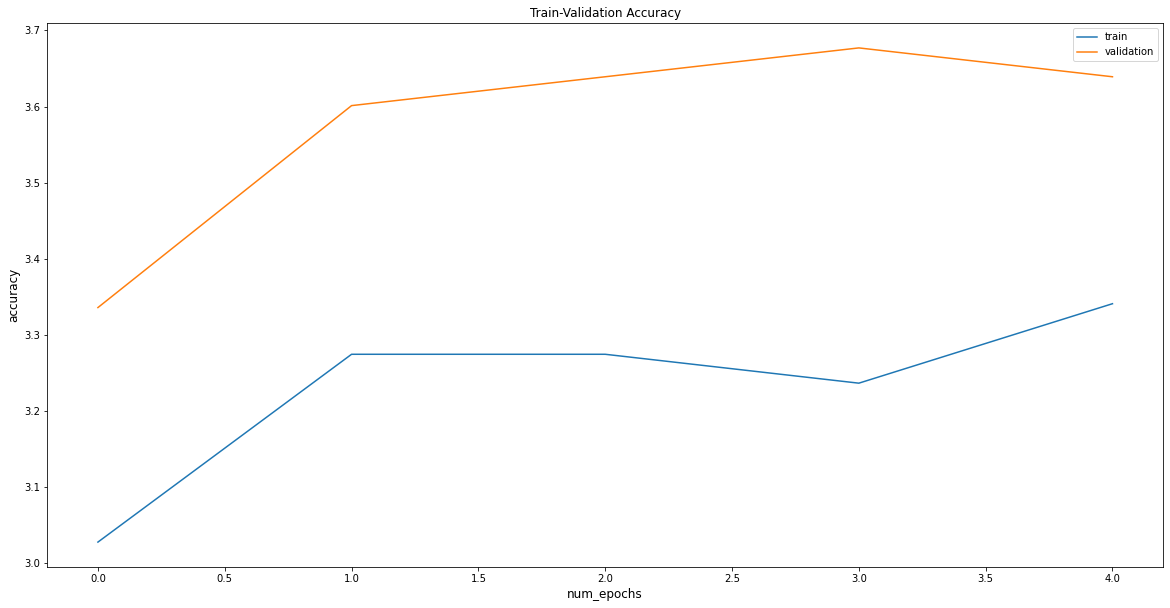

In [14]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=False)
resnet50.load_state_dict(torch.load(modelPath+'/traiend_resnet50.h5'))

validation_img_paths = ["/validation/Bombus_affinis/3RXQJRKQDRSQDR0QL0SQURG0URZQUR3KBRRQWRFKWRRQ3RHQ9RLQ1RJKTQI09RFKWR50TQI0ARFKCQ20.jpg",
                        "/validation/Bombus_melanopygus/8HOH7HCH2H2ZIL9ZILAZSL2Z0L2ZXHPZGHRR2HAZ2HBHLL1HHLEZLL5ZQLEZ5LHRILLR5HBH4H8ZMLFH8LJH4LZRPHLR.jpg",
                        "/validation/Bombus_vagans/4KDKMKTKZKZSGQB05QA05QT05QT06Q2KXKVKWQDKGKF08KTK4KCKSKO0VQAK8KWKKKWKQKB00KWK2QA0RKPKSK9KGQ.jpg"]

img_list = [Image.open(DATADIR + img_path) for img_path in validation_img_paths]                        

Using cache found in C:\Users\kuo19/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub


OVER SAMPLEING